In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/julia_codes/GECaM`


In [2]:
using DifferentialEquations
using DifferentialEquations.EnsembleAnalysis
using Plots, GraphRecipes
using SparseArrays, LinearAlgebra
using Statistics
using Graphs

In [87]:
function norm_wealth!(sol::RODESolution)
    sol.u .= [u./mean(u) for u in sol.u];
end

function norm_wealth(sol::RODESolution)
    norm_wealth!(sol)
    return sol
end

function norm_wealth!(sim::EnsembleSolution)
    sim.u .= [norm_wealth(sol) for sol in sim]
end

function timeseries_point_meancor(sim, start_time, τs)
    return [timepoint_meancor(sim, start_time, τ+start_time)[3] for τ in τs]
end

function equaltime_point_meancor(sim, ts)
    return [timepoint_meancor(sim, t, t)[3] for t in ts]
end

function Y2_t(sim, t)
    return mean([sum(sol(t).^2) for sol in sim])
end

function Y2(sim, ts)
    return [Y2_t(sim, t) for t in ts]
end

Y2 (generic function with 1 method)

In [28]:
NV = 5000 # number of graph vertices
K = 10 # degree
σ = 1.0 # noise amplitude
J = 0.3 # coupling

# generate a random K-regualr graph with NV vertices
G = random_regular_graph(NV, K)

Amod = adjacency_matrix(G)

for i in 1:NV
    Amod[i,i] = -sum(Amod[:,i])
end

display(sparse(Amod))

5000×5000 SparseMatrixCSC{Int64, Int64} with 55000 stored entries:
⎡⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⣷⣿⣿⎤
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⎥
⎣⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⎦

## Single realization

In [5]:
f!(du, u, p, t) = mul!(du, p[1], J.*u)

g!(du, u, p, t) = mul!(du, sqrt(2)*p[2], u)

u₀ = ones(NV,1)#rand(NV,1).*10 .+ 1

tspan = (0.0, 1000.0)
p = (Amod, σ)

prob = SDEProblem(f!, g!, u₀, tspan, p)

SDEProblem with uType Matrix{Float64} and tType Float64. In-place: true
timespan: (0.0, 1000.0)
u0: 5000×1 Matrix{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [58]:
sol = solve(prob, EM(), dt=0.1);
sol.u

10001-element Vector{Matrix{Float64}}:
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.1486228959944687; 1.8117080483723091; … ; 0.8074514136410134; 1.0031736721430349;;]
 [0.8484906340430165; -0.34755363352914737; … ; 0.24287765495129998; 0.9272420459437493;;]
 [1.2682236665004827; 0.24760151767291347; … ; 0.4662013286475464; -0.029580970165998255;;]
 [2.635115600977307; 0.5126433233069541; … ; 0.905331007638461; 0.24242127801343774;;]
 [2.817291252327395; 0.7312329049857069; … ; 1.1897732413491582; 0.45187068704701067;;]
 [2.0600670959749667; 0.7118155933820765; … ; 1.1270397658890787; 0.7617682116773484;;]
 [2.2328856237878254; 0.7606047639932628; … ; 1.2372102411934056; 0.4540719099730681;;]
 [3.2388493745325118; 0.3627571561738574; … ; 1.1815490054729907; 0.4403836464116625;;]
 [2.1640870037228073; 0.4487955320055941; … ; 1.8661990551283736; 0.5651226699426398;;]
 [0.7353997394954617; 0.419983814351778; … ; 1.085538004567494; 1.1911110506324705;;]
 [0.5615031864158488; 0.5757890500567379; … ; 1.0

In [62]:
norm_wealth!(sol)

10001-element Vector{Matrix{Float64}}:
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.1452265994728126; 1.8063511137644404; … ; 0.8050639073174685; 1.0002074460080712;;]
 [0.8406432864513085; -0.34433925017635947; … ; 0.24063137749791194; 0.9186663583118241;;]
 [1.2610939143711613; 0.24620954124597694; … ; 0.4635804187848648; -0.029414670647546284;;]
 [2.5933262839701468; 0.5045135037493859; … ; 0.8909737003307345; 0.238576809242342;;]
 [2.7819329874541943; 0.722055605082076; … ; 1.1748410552033641; 0.446199507885877;;]
 [2.021305198642907; 0.6984221835247256; … ; 1.1058335635377587; 0.7474349012383068;;]
 [2.1807438918522917; 0.7428433304068217; … ; 1.2083192473794147; 0.44346854741967956;;]
 [3.140481203990343; 0.3517397380486157; … ; 1.145663788028733; 0.4270086083580768;;]
 [2.1043213565625067; 0.436401134106238; … ; 1.8146601872049402; 0.5495156624443382;;]
 [0.7130668468273923; 0.4072295897518623; … ; 1.05257198290457; 1.1549389474606955;;]
 [0.547019938176086; 0.5609373164469255; … ; 1.0466350

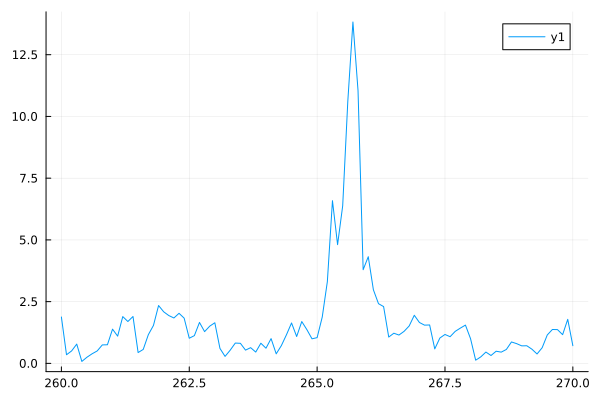

In [63]:
plot(260:0.1:270, sol(260:0.1:270)[200,:])

## Multiple realizations

In [11]:
function prob_func(prob, i, repeat)
    remake(prob, u0 = rand(NV,1).*10 .+ 1)
end

ensemble_prob = EnsembleProblem(prob)#, prob_func = prob_func)

EnsembleProblem with problem SDEProblem

In [12]:
sim = solve(ensemble_prob, EM(), dt=0.1, EnsembleThreads(), trajectories = 10)

EnsembleSolution Solution of length 10 with uType:
RODESolution{Float64, 3, Vector{Matrix{Float64}}, Nothing, Nothing, Vector{Float64}, NoiseProcess{Float64, 3, Float64, Matrix{Float64}, Nothing, Nothing, typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE), true, ResettableStacks.ResettableStack{Tuple{Float64, Matrix{Float64}, Nothing}, true}, ResettableStacks.ResettableStack{Tuple{Float64, Matrix{Float64}, Nothing}, true}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SDEProblem{Matrix{Float64}, Tuple{Float64, Float64}, true, Tuple{SparseMatrixCSC{Int64, Int64}, Float64}, Nothing, SDEFunction{true, SciMLBase.FullSpecialize, typeof(f!), typeof(g!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, typeof(g!), Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), 

In [38]:
norm_wealth!(sim)

10-element Vector{RODESolution{Float64, 3, Vector{Matrix{Float64}}, Nothing, Nothing, Vector{Float64}, NoiseProcess{Float64, 3, Float64, Matrix{Float64}, Nothing, Nothing, typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE), true, ResettableStacks.ResettableStack{Tuple{Float64, Matrix{Float64}, Nothing}, true}, ResettableStacks.ResettableStack{Tuple{Float64, Matrix{Float64}, Nothing}, true}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SDEProblem{Matrix{Float64}, Tuple{Float64, Float64}, true, Tuple{SparseMatrixCSC{Int64, Int64}, Float64}, Nothing, SDEFunction{true, SciMLBase.FullSpecialize, typeof(f!), typeof(g!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, typeof(g!), Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Nothing}, EM{true}, St

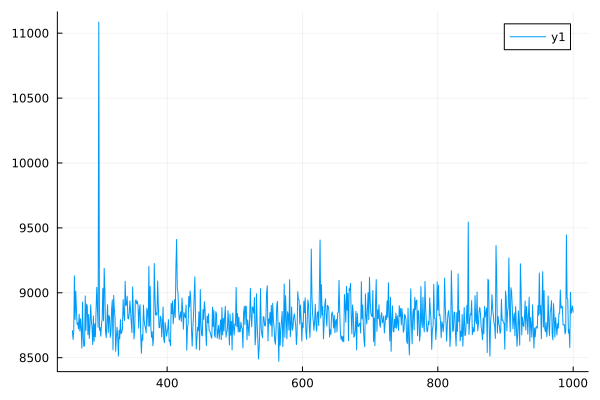

In [89]:
plot(260:1000, Y2(sim, 260:1000))